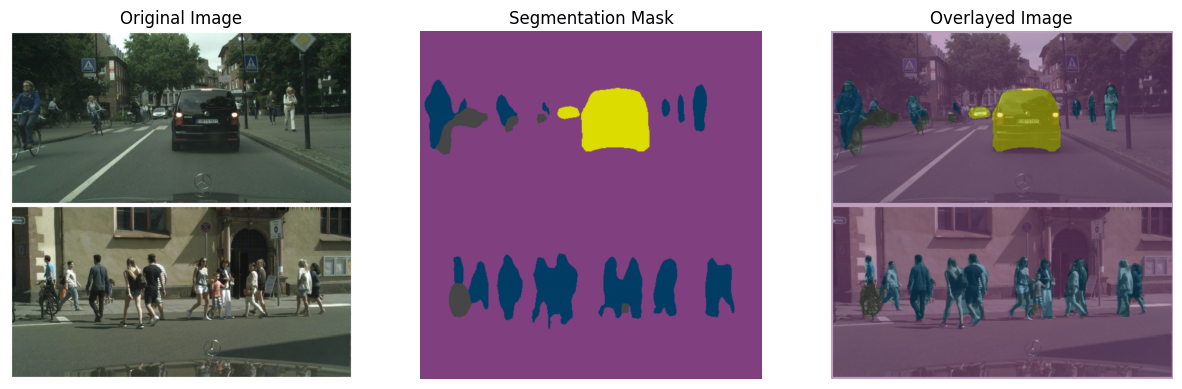

In [3]:
import cv2
import torch
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchvision import models

# Load pre-trained DeepLabV3 model
model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

# Load image
image_path = r"/content/1_KICInky28yGdU9T45kIL5Q.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Original image shape
original_shape = image.shape

# Transform the image for model input
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Perform segmentation
with torch.no_grad():
    output = model(input_tensor)["out"][0]  # Get model output

# Convert output to segmentation mask
segmentation_map = torch.argmax(output, dim=0).byte().cpu().numpy()

# Define color map (Pascal VOC colormap)
def get_colored_mask(segmentation_map):
    label_colors = np.array([
        [128, 64, 128], [244, 35, 232], [70, 70, 70], [102, 102, 156], [190, 153, 153],
        [153, 153, 153], [250, 170, 30], [220, 220, 0], [107, 142, 35], [152, 251, 152],
        [70, 130, 180], [220, 20, 60], [255, 0, 0], [0, 0, 142], [0, 0, 70],
        [0, 60, 100], [0, 80, 100], [0, 0, 230], [119, 11, 32]
    ])

    colored_mask = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8)
    for label in np.unique(segmentation_map):
        colored_mask[segmentation_map == label] = label_colors[label % len(label_colors)]

    return colored_mask

# Create segmentation mask
segmentation_mask = get_colored_mask(segmentation_map)

# Resize the segmentation mask to the original image size
segmentation_mask = cv2.resize(segmentation_mask, (original_shape[1], original_shape[0])) # Resize to original shape

# Blend the segmentation mask with the original image
blended = cv2.addWeighted(image, 0.5, segmentation_mask, 0.5, 0)

# Show results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[1].imshow(segmentation_mask)
ax[1].set_title("Segmentation Mask")
ax[2].imshow(blended)
ax[2].set_title("Overlayed Image")

for a in ax:
    a.axis("off")

plt.show()